# Sentinel-2 Bathymetry workflow per Gebco Cookbook

In [1]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio import Affine
from rasterio.enums import Resampling
from rasterstats import point_query
import earthpy.plot as ep
import zipfile
from scipy import ndimage, stats
import matplotlib.pyplot as plt
import plotly.express as px

# Paths and Input Files

In [2]:
# Directories and Source Files
tile = 'T16QDF'
source_dir = '/Users/arbailey/natcap/idb/data/source/sentinel'
work_dir = '/Users/arbailey/natcap/idb/data/work/sentinel'

In [3]:
# Find the ZIP file and associated band files from the source data
os.chdir(source_dir)
# S2 = Sentinel-2, MSIL1C_ = Level 1C
# Assumes there is only one zip file matching the specified tile
S2_L1C_zip = glob.glob('S2*MSIL1C_*' + tile + '*.zip')[0]
print(S2_L1C_zip)
S2_L1C = os.path.splitext(S2_L1C_zip)[0]
print(S2_L1C)
# https://rasterio.readthedocs.io/en/latest/topics/switch.html
prefix_rio = r"zip://"  # Rasterio format
prefix_gdal = "SENTINEL2_L1C:" + r"/vsizip/"  # GDAL format
S2_L1C_10m_xml = prefix_gdal + os.path.join(S2_L1C_zip, S2_L1C + ".SAFE", "MTD_MSIL1C.xml:10m:EPSG_32616")
print(S2_L1C_10m_xml)
S2_L1C_20m_xml = prefix_gdal + os.path.join(S2_L1C_zip, S2_L1C + ".SAFE", "MTD_MSIL1C.xml:20m:EPSG_32616")
print(S2_L1C_20m_xml)
# Get name of all the files in the zip file and pull out the Blue, Green, and SWIR bands
with zipfile.ZipFile(S2_L1C_zip) as myzip:
    zipfilelist = myzip.namelist()
S2_L1C_blue = [f for f in zipfilelist if f.endswith("B02.jp2")][0]
S2_L1C_green = [f for f in zipfilelist if f.endswith("B03.jp2")][0]
S2_L1C_swir = [f for f in zipfilelist if f.endswith("B11.jp2")][0]
print(S2_L1C_blue)
print(S2_L1C_green)
print(S2_L1C_swir)

S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip
S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628
SENTINEL2_L1C:/vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/MTD_MSIL1C.xml:10m:EPSG_32616
SENTINEL2_L1C:/vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/MTD_MSIL1C.xml:20m:EPSG_32616
S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B02.jp2
S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B03.jp2
S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B11.jp2


# Explore Sentinel-2 Metadata

In [4]:
# Looking at the Sentinel-2 top-level metadata
!gdalinfo {S2_L1C_zip}  # $S2_L1C_zip also works

Driver: SENTINEL2/Sentinel 2
Files: S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip
Size is 512, 512
Coordinate System is `'
Metadata:
  CLOUD_COVERAGE_ASSESSMENT=0.0
  DATATAKE_1_DATATAKE_SENSING_START=2020-02-06T16:14:31.024Z
  DATATAKE_1_DATATAKE_TYPE=INS-NOBS
  DATATAKE_1_ID=GS2A_20200206T161431_024161_N02.09
  DATATAKE_1_SENSING_ORBIT_DIRECTION=DESCENDING
  DATATAKE_1_SENSING_ORBIT_NUMBER=140
  DATATAKE_1_SPACECRAFT_NAME=Sentinel-2A
  DEGRADED_ANC_DATA_PERCENTAGE=0.0
  DEGRADED_MSI_DATA_PERCENTAGE=0
  FOOTPRINT=POLYGON((-87.95041 18.990081461066513, -86.90729 18.99249851825736, -86.90781 18.000108747223248, -87.94495 17.997826621161874, -87.95041 18.990081461066513))
  FORMAT_CORRECTNESS=PASSED
  GENERAL_QUALITY=PASSED
  GENERATION_TIME=2020-02-06T19:46:28.000000Z
  GEOMETRIC_QUALITY=PASSED
  PREVIEW_GEO_INFO=Not applicable
  PREVIEW_IMAGE_URL=Not applicable
  PROCESSING_BASELINE=02.09
  PROCESSING_LEVEL=Level-1C
  PRODUCT_START_TIME=2020-02-06T16:14:31.024Z
  PRO

In [5]:
# Metadata for the different subdata sets (10m & 20m)
!gdalinfo {S2_L1C_10m_xml}
!gdalinfo {S2_L1C_20m_xml}

Driver: SENTINEL2/Sentinel 2
Files: /vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/MTD_MSIL1C.xml
       /vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/MTD_TL.xml
       /vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B04.jp2
       /vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B03.jp2
       /vsizip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANUL

  Overviews: 2745x2745, 1372x1372, 686x686, 343x343
  Metadata:
    BANDNAME=B5
    BANDWIDTH=15
    BANDWIDTH_UNIT=nm
    SOLAR_IRRADIANCE=1424.64
    SOLAR_IRRADIANCE_UNIT=W/m2/um
    WAVELENGTH=705
    WAVELENGTH_UNIT=nm
  Image Structure Metadata:
    NBITS=15
Band 2 Block=128x128 Type=UInt16, ColorInterp=Undefined
  Description = B6, central wavelength 740 nm
  Overviews: 2745x2745, 1372x1372, 686x686, 343x343
  Metadata:
    BANDNAME=B6
    BANDWIDTH=15
    BANDWIDTH_UNIT=nm
    SOLAR_IRRADIANCE=1287.61
    SOLAR_IRRADIANCE_UNIT=W/m2/um
    WAVELENGTH=740
    WAVELENGTH_UNIT=nm
  Image Structure Metadata:
    NBITS=15
Band 3 Block=128x128 Type=UInt16, ColorInterp=Undefined
  Description = B7, central wavelength 783 nm
  Overviews: 2745x2745, 1372x1372, 686x686, 343x343
  Metadata:
    BANDNAME=B7
    BANDWIDTH=20
    BANDWIDTH_UNIT=nm
    SOLAR_IRRADIANCE=1162.08
    SOLAR_IRRADIANCE_UNIT=W/m2/um
    WAVELENGTH=783
    WAVELENGTH_UNIT=nm
  Image Structure Metadata:
    NBITS=15
B

# Get Data for Sentinel-2 bands: blue (B02), green (B03), and SWIR (B11)

In [6]:
# Example ZIP for Rasterio: 'zip:///path/to/file.zip!/folder/file.tif'
# https://rasterio.readthedocs.io/en/latest/topics/datasets.html

blue_source = prefix_rio + S2_L1C_zip + r"!/" + S2_L1C_blue
print(blue_source)
with rasterio.open(blue_source) as src:
    blue_meta = src.meta
    blue_profile = src.profile
    blue_np = src.read(1)
    print(blue_np)
    print(blue_meta)
    print(blue_profile)

zip://S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip!/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B02.jp2
[[1121 1119 1100 ... 1033 1037 1030]
 [1104 1092 1076 ... 1021 1090 1118]
 [1113 1088 1080 ... 1061 1097 1104]
 ...
 [ 992  989  997 ... 1027 1010  977]
 [ 994  996  994 ... 1049 1040 1035]
 [ 994  998  976 ...  999 1009 1015]]
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


In [7]:
green_source = prefix_rio + S2_L1C_zip + r"!/" + S2_L1C_green
print(green_source)
with rasterio.open(green_source) as src:
    green_profile = src.profile
    green_np = src.read(1)
    print(green_np)
    print(green_profile)

zip://S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip!/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B03.jp2
[[ 987  992  995 ...  671  681  770]
 [ 993  979  984 ...  698  741  783]
 [1001  999  999 ...  679  700  687]
 ...
 [ 860  863  880 ...  684  660  596]
 [ 874  869  852 ...  692  669  639]
 [ 876  876  863 ...  657  660  647]]
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


In [8]:
swir_source = prefix_rio + S2_L1C_zip + r"!/" + S2_L1C_swir
print(swir_source)
with rasterio.open(swir_source) as src:
    swir_profile = src.profile
    swir_np = src.read(1)
    print(swir_np)
    print(swir_profile)

zip://S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.zip!/S2A_MSIL1C_20200206T161431_N0209_R140_T16QDF_20200206T194628.SAFE/GRANULE/L1C_T16QDF_A024161_20200206T162504/IMG_DATA/T16QDF_20200206T161431_B11.jp2
[[1302  879  777 ...  210  257  304]
 [1104  800  945 ...  193  226  234]
 [1187 1012 1252 ...  211  241  241]
 ...
 [1394 1382 1386 ...  225  251  251]
 [1377 1388 1390 ...  222  264  262]
 [1390 1400 1390 ...  266  293  264]]
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 5490, 'height': 5490, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(20.0, 0.0, 399960.0,
       0.0, -20.0, 2100000.0), 'blockxsize': 640, 'blockysize': 640, 'tiled': True}


# Resample (NN) the SWIR band from 20m to 10m to match the visible bands

In [9]:
# https://rasterio.readthedocs.io/en/latest/topics/resampling.html
# https://gist.github.com/lpinner/13244b5c589cda4fbdfa89b30a44005b
# https://gis.stackexchange.com/questions/283103/rasterio-use-case-for-src-meta-vs-src-profile-when-reading-and-writing-rasters

""" Resample a raster
        multiply the pixel size by the scale factor
        divide the dimensions by the scale factor
        i.e
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 2,
        the resampled raster would have an output pixel size of 500m and dimensions of (512, 512)
        given a pixel size of 250m, dimensions of (1024, 1024) and a scale of 0.5,
        the resampled raster would have an output pixel size of 125m and dimensions of (2048, 2048)
"""

scale = 0.5 
with rasterio.open(swir_source) as src:
 
    # Rescaled height and width values
    height = int(src.height / scale)
    width = int(src.width / scale)

    # update the profile & metadata
    t = src.transform
    transform = Affine(t.a * scale, t.b, t.c, t.d, t.e * scale, t.f)
    profile = src.profile
    profile.update(transform=transform, height=height, width=width)
    meta = src.meta
    meta.update(transform=transform, height=height, width=width)
    swirrs_meta = meta

    # resample the raster
    swir_10m = src.read(
            indexes=1,
            out_shape=(src.count, height, width),
            resampling=Resampling.nearest,
            )

    print(swir_10m)
    print(swirrs_meta)
    print(profile)

[[1302 1302  879 ...  257  304  304]
 [1302 1302  879 ...  257  304  304]
 [1104 1104  800 ...  226  234  234]
 ...
 [1377 1377 1388 ...  264  262  262]
 [1390 1390 1400 ...  293  264  264]
 [1390 1390 1400 ...  293  264  264]]
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0)}
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0), 'blockxsize': 640, 'blockysize': 640, 'tiled': True}


# Neighborhood Filter the Blue & Green bands

In [10]:
filter_size = 3 # square neighborhood
blue_filtered = ndimage.median_filter(blue_np, size=filter_size)

green_filtered = ndimage.median_filter(green_np, size=filter_size)

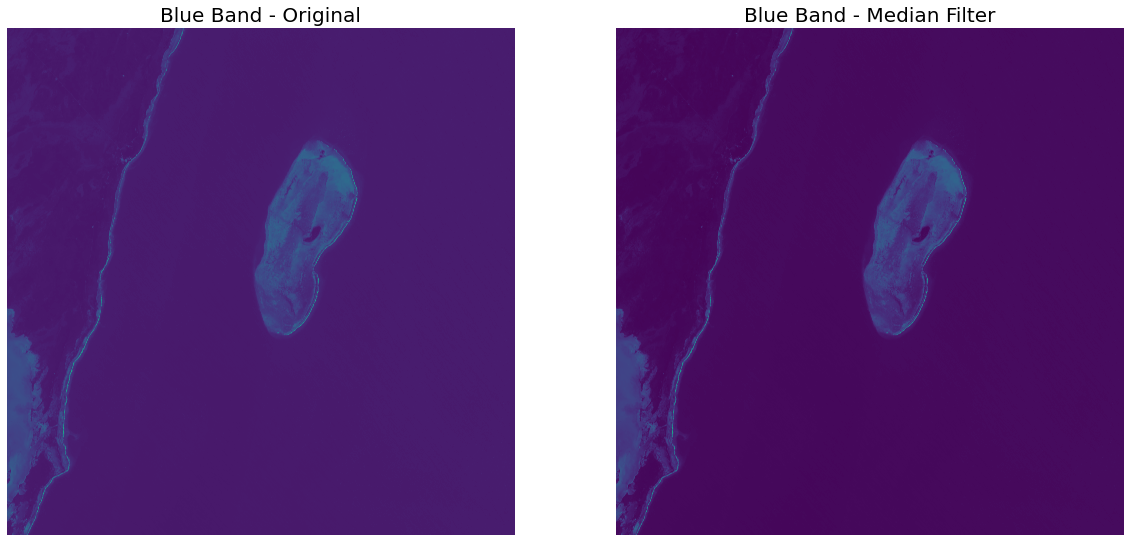

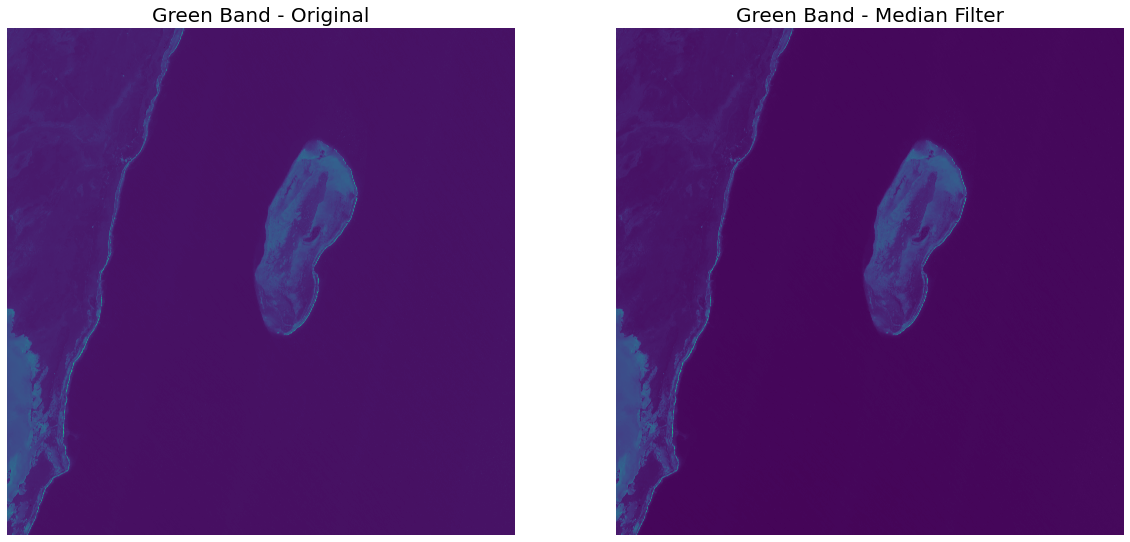

In [11]:
# Plot Original and Filtered Bands
# Blue
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
# plt.axis('off')
ax1.imshow(blue_np)
ax1.axis('off')
ax1.set_title('Blue Band - Original', fontdict={'fontsize':20})
ax2.imshow(blue_filtered)
ax2.axis('off')
ax2.set_title('Blue Band - Median Filter', fontdict={'fontsize':20})
plt.show()
# Green
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(green_np)
ax1.axis('off')
ax1.set_title('Green Band - Original', fontdict={'fontsize':20})
ax2.imshow(green_filtered)
ax2.axis('off')
ax2.set_title('Green Band - Median Filter', fontdict={'fontsize':20})
plt.show()


# Mask the Blue and Green Bands with the SWIR land/water threshold

In [12]:
# https://www.science-emergence.com/Articles/How-to-mask-an-array-using-another-array-in-python-/
# https://numpy.org/doc/stable/reference/generated/numpy.ma.masked_where.html?highlight=masked_where
swir_threshold = 800
blue_masked = np.ma.masked_where(swir_10m > swir_threshold, blue_filtered)
print(blue_filtered)
print(blue_masked)
green_masked = np.ma.masked_where(swir_10m > swir_threshold, green_filtered)
print(green_filtered)
print(green_masked)

[[1119 1104 1092 ... 1033 1033 1037]
 [1113 1100 1086 ... 1037 1061 1097]
 [1104 1092 1086 ... 1048 1061 1097]
 ...
 [ 994  994  994 ... 1074 1035 1010]
 [ 994  994  996 ... 1035 1015 1015]
 [ 994  994  994 ... 1035 1015 1015]]
[[-- -- -- ... 1033 1033 1037]
 [-- -- -- ... 1037 1061 1097]
 [-- -- 1086 ... 1048 1061 1097]
 ...
 [-- -- -- ... 1074 1035 1010]
 [-- -- -- ... 1035 1015 1015]
 [-- -- -- ... 1035 1015 1015]]
[[ 987  992  992 ...  671  698  770]
 [ 993  993  995 ...  679  698  741]
 [1001  999  999 ...  666  687  687]
 ...
 [ 863  866  869 ...  684  671  660]
 [ 874  869  875 ...  684  660  647]
 [ 876  874  875 ...  669  657  647]]
[[-- -- -- ... 671 698 770]
 [-- -- -- ... 679 698 741]
 [-- -- 999 ... 666 687 687]
 ...
 [-- -- -- ... 684 671 660]
 [-- -- -- ... 684 660 647]
 [-- -- -- ... 669 657 647]]


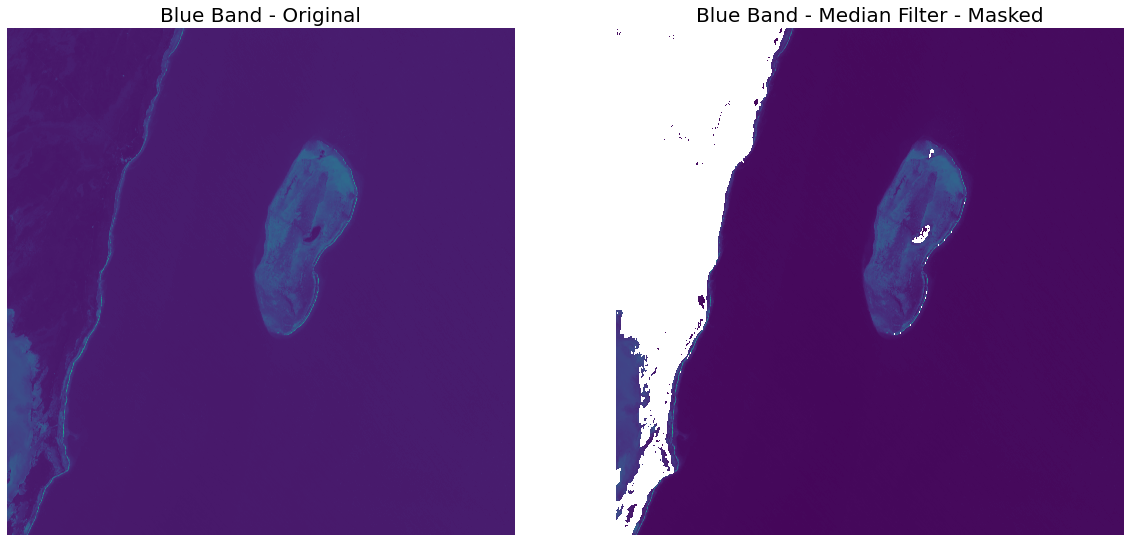

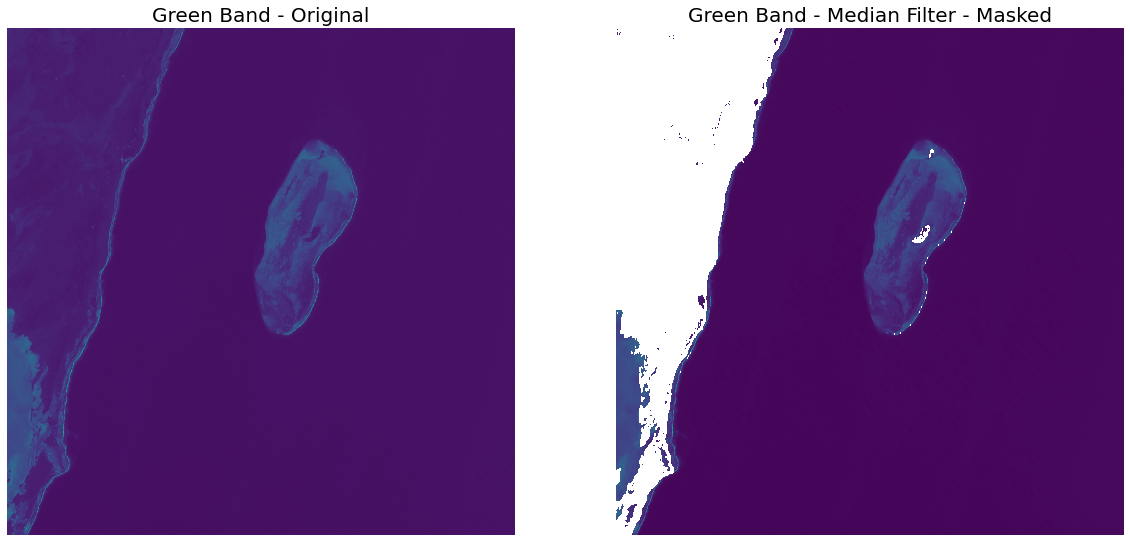

In [13]:
# Plot Original and Masked Bands
# Blue
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
# plt.axis('off')
ax1.imshow(blue_np)
ax1.axis('off')
ax1.set_title('Blue Band - Original', fontdict={'fontsize':20})
ax2.imshow(blue_masked)
ax2.axis('off')
ax2.set_title('Blue Band - Median Filter - Masked', fontdict={'fontsize':20})
plt.show()
# Green
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(green_np)
ax1.axis('off')
ax1.set_title('Green Band - Original', fontdict={'fontsize':20})
ax2.imshow(green_masked)
ax2.axis('off')
ax2.set_title('Green Band - Median Filter - Masked', fontdict={'fontsize':20})
plt.show()

# Calculate Relative Bathymetry per Stumpf et al (2003) ratio method

In [14]:
relative_bathy = np.log(blue_masked) / np.log(green_masked)
print(relative_bathy)

[[-- -- -- ... 1.0662879943847656 1.0598640441894531 1.0447907447814941]
 [-- -- -- ... 1.0649425983428955 1.063948392868042 1.0593725442886353]
 [-- -- 1.0120898485183716 ... 1.0697321891784668 1.0665355920791626
  1.071643590927124]
 ...
 [-- -- -- ... 1.069116234779358 1.0665851831436157 1.0655344724655151]
 [-- -- -- ... 1.0634499788284302 1.0662951469421387 1.0695725679397583]
 [-- -- -- ... 1.0670745372772217 1.0670439004898071 1.0695725679397583]]


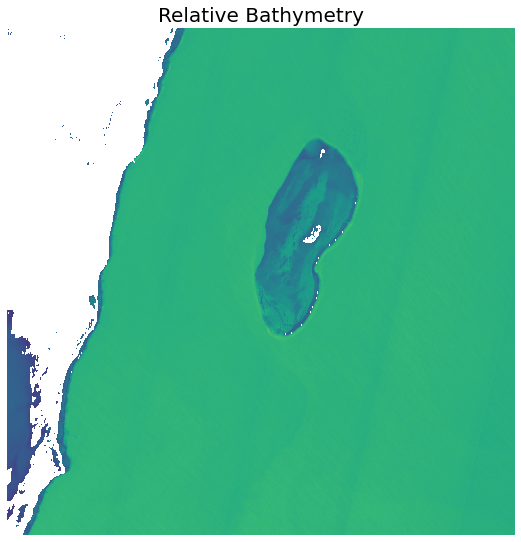

In [15]:
# Plot Relative Bathy
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121)  # left side
# plt.axis('off')
ax1.imshow(relative_bathy)
ax1.axis('off')
ax1.set_title('Relative Bathymetry', fontdict={'fontsize':20})
plt.show()

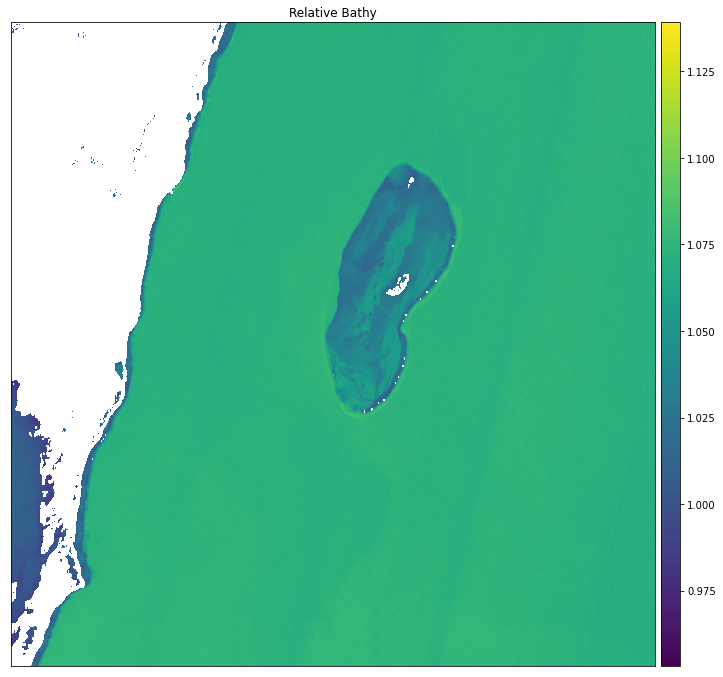

In [16]:
# Plot with earthpy package 
ep.plot_bands(relative_bathy, 
              cmap='viridis',
              title="Relative Bathy",
              scale=False)
plt.show()

In [17]:
# Describe results
print(relative_bathy.shape)
print(relative_bathy.ndim)
print(relative_bathy.dtype)
stats.describe(relative_bathy, axis=None)

(10980, 10980)
2
float32


DescribeResult(nobs=120560400, minmax=(0.95313567, 1.1391349), mean=1.067391886385308, variance=0.0002864256747286696, skewness=-1.3272593021392822, kurtosis=0.02051923390684607)

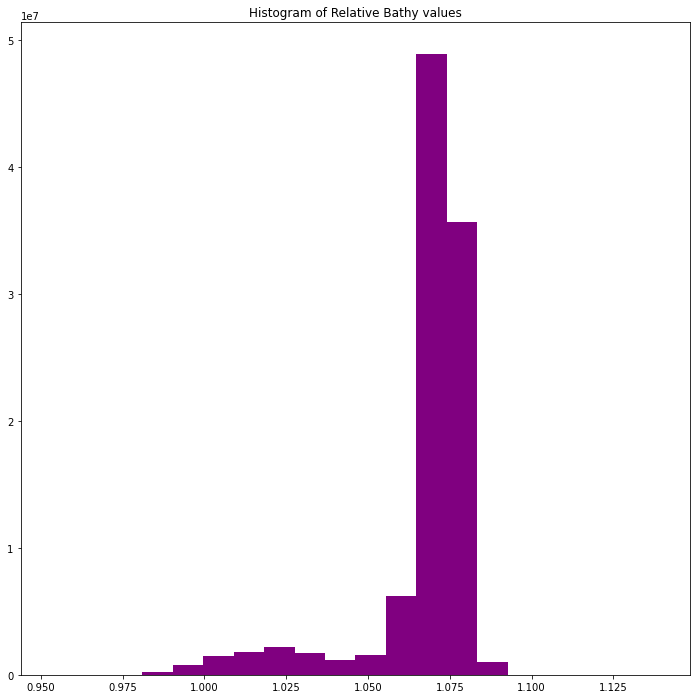

In [18]:
# Histogram with earthpy package -- Much faster than above
ep.hist(relative_bathy, 
        colors = 'purple',
        title="Histogram of Relative Bathy values")
plt.show()

In [19]:
# Output Relative Bathy as intermediate product
relbathy_profile = blue_profile
relbathy_profile.update(driver='GTiff', dtype='float32')
print(relbathy_profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


In [20]:
# Export to GeoTiff
# Fill masked cells with no data value
nodatavalue = -9999.0
relative_bathy_nd = np.ma.filled(relative_bathy, fill_value=nodatavalue)
relbathy_profile.update({'nodata': nodatavalue})
print(relbathy_profile)
out_file = tile + "_relbathy.tif"
out_path = os.path.join(work_dir, out_file)
print(out_path)

with rasterio.open(out_path, 'w', **relbathy_profile) as outf:
    outf.write(relative_bathy_nd, 1)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(10.0, 0.0, 399960.0,
       0.0, -10.0, 2100000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}
/Users/arbailey/natcap/idb/data/work/sentinel/T16QDF_relbathy.tif


# Sample Relative Bathy Raster with Sounding Points

In [21]:
soundingpts_shp = "soundings_T16QDF_relativebathy_32616.shp"
soundingpts_path = os.path.join(work_dir, soundingpts_shp)
depth_pts = gpd.read_file(soundingpts_path)
depth_pts

id  dep_dig  dep_m  rvalue_1                        geometry
0      1     18.0   5.49  1.057713  POINT (458210.884 2036777.167)
1      2      8.0   2.44  1.056592  POINT (457216.051 2039147.834)
2      3      5.0   1.52  1.029552  POINT (461971.496 2041412.667)
3      4     12.0   3.66  1.041656  POINT (457851.051 2042612.111)
4      5    165.0  50.29  1.073717  POINT (452227.773 2035782.334)
..   ...      ...    ...       ...                             ...
708  788      4.0   1.22  1.005254  POINT (411668.985 2010203.834)
709  789      5.0   1.52  1.011337  POINT (411673.488 2010530.634)
710  790      5.0   1.52  1.012959  POINT (411959.712 2014794.693)
711  791      5.0   1.52  1.013252  POINT (411827.144 2014912.005)
712  792      6.0   1.83  1.012606  POINT (412019.044 2015197.307)

[713 rows x 5 columns]

In [22]:
# Relative bathy values sampled from raster at sounding point locations
relbathy_pts = point_query(depth_pts, relative_bathy, 
                           affine=relbathy_profile['transform'], 
                           geojson_out=True,
                           property_name='reldep'
                          )
print(type(relbathy_pts))
relbathy_pts  # GeoJSOn object   -- list of GeoJSON objects

/Users/arbailey/miniconda3/envs/geoenv/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


<class 'list'>


[{'id': '0',
  'type': 'Feature',
  'properties': {'dep_dig': 18.0,
   'dep_m': 5.49,
   'id': 1,
   'rvalue_1': 1.057712912559509,
   'reldep': 1.0569395710332468},
  'geometry': {'type': 'Point',
   'coordinates': (458210.8844489725, 2036777.1669574846)},
  'bbox': (458210.8844489725,
   2036777.1669574846,
   458210.8844489725,
   2036777.1669574846)},
 {'id': '1',
  'type': 'Feature',
  'properties': {'dep_dig': 8.0,
   'dep_m': 2.44,
   'id': 2,
   'rvalue_1': 1.056591629981995,
   'reldep': 1.056637150702134},
  'geometry': {'type': 'Point',
   'coordinates': (457216.05111462506, 2039147.8336265713)},
  'bbox': (457216.05111462506,
   2039147.8336265713,
   457216.05111462506,
   2039147.8336265713)},
 {'id': '2',
  'type': 'Feature',
  'properties': {'dep_dig': 5.0,
   'dep_m': 1.52,
   'id': 3,
   'rvalue_1': 1.029552221298218,
   'reldep': 1.029919327019728},
  'geometry': {'type': 'Point',
   'coordinates': (461971.4955639203, 2041412.6669622127)},
  'bbox': (461971.495563920

In [23]:
from geojson import Feature, Point, FeatureCollection
collection = FeatureCollection(relbathy_pts)
depth_relbathy_pts = gpd.GeoDataFrame.from_features(collection['features'])

# Find Extinction Depth and Best Fit Linear Regression between depth points and relative bathymetry raster

In [24]:
# Change min/max variables and rerun cell to view updates to visualize approximate extinction depth value
min = 0 
max = 100
fig = px.scatter(depth_relbathy_pts[(depth_relbathy_pts["dep_m"] >= min) & 
                                        (depth_relbathy_pts["dep_m"] <= max)],
                                        x="reldep", y="dep_m")
fig.show()

In [25]:
# Use approximate extinction depth to plot regression 
min = 0
max = 25
fig = px.scatter(depth_relbathy_pts[(depth_relbathy_pts["dep_m"] >= min) & 
                                    (depth_relbathy_pts["dep_m"] <= max)], 
                                     x="reldep", y="dep_m", trendline="ols")
fig.show()
# https://www.statsmodels.org/stable/regression.html
results = px.get_trendline_results(fig)
print(results)
regression_params = results.px_fit_results.iloc[0].params
print(regression_params)
results.px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...
[-251.06986366  248.28440778]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     1574.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):          6.47e-168
Time:                        15:43:46   Log-Likelihood:                -1514.5
No. Observations:                 586   AIC:                             3033.
Df Residuals:                     584   BIC:                             3042.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -251.0699      6.498    -38.641      0.000    -263.831    -238.309
x1           248.2844      6.257     39.679      0.000     235.995     260.574
==============================================================================
Omnibus:                       37.673   Durbin-Watson:                   1.594
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.704
Skew:                           0.445   Prob(JB):                     8.90e-15
Kurtosis:                       4.363   Cond. No.                         98.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Apply regression to Relative Bathy per Stumpf (2003) equation

In [26]:
m0 = regression_params[0]
m1 = regression_params[1]
print(m1)
print(m0)

248.28440777873146
-251.06986365804966


In [27]:
sdb_grid = m1 * (relative_bathy) + m0
sdb_grid

masked_array(
  data=[[--, --, --, ..., 13.672805786132812, 12.077835083007812,
         8.335372924804688],
        [--, --, --, ..., 13.338760375976562, 13.091934204101562,
         11.955825805664062],
        [--, --, 0.2162628173828125, ..., 14.527938842773438,
         13.734298706054688, 15.002517700195312],
        ...,
        [--, --, --, ..., 14.375015258789062, 13.746597290039062,
         13.485733032226562],
        [--, --, --, ..., 12.968185424804688, 13.674575805664062,
         14.488327026367188],
        [--, --, --, ..., 13.868087768554688, 13.860488891601562,
         14.488327026367188]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dty

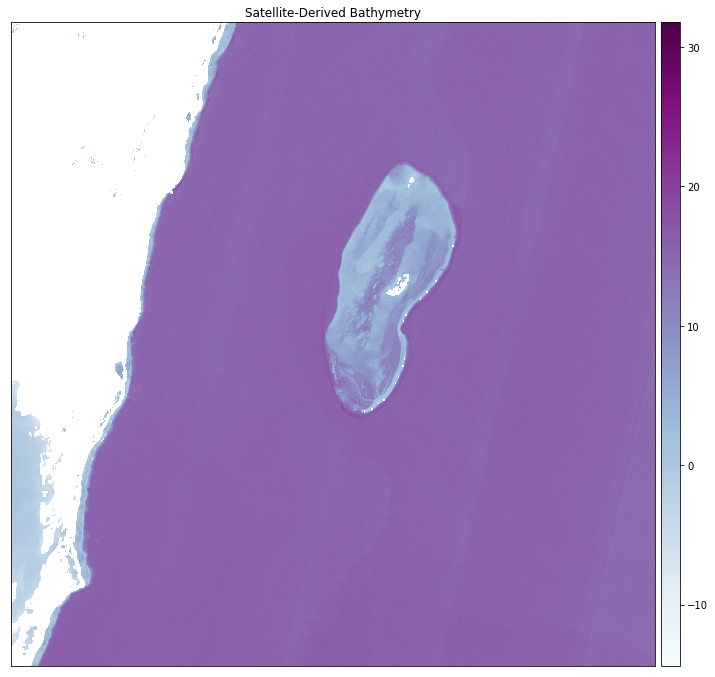

In [28]:
# Plot SDB grid
ep.plot_bands(sdb_grid, 
              cmap='BuPu',
              title="Satellite-Derived Bathymetry",
              scale=False)
plt.show()

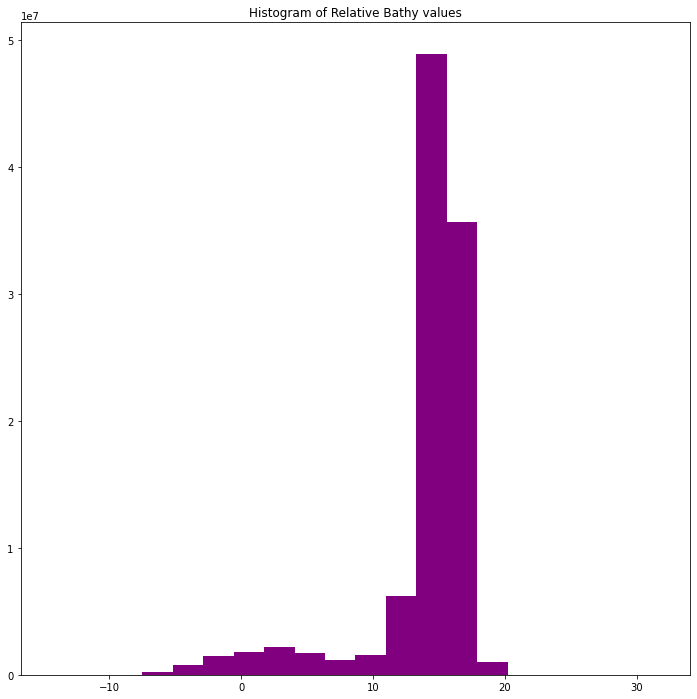

In [29]:
# SDB histogram
ep.hist(sdb_grid, 
        colors = 'purple',
        title="Histogram of Relative Bathy values")
plt.show()